<a href="https://colab.research.google.com/github/chang-heekim/Implementation_Deep_Learning_Paper/blob/main/VAE_for_MNIST_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os 

import torch
import torch.nn.functional as F
from torch import nn, optim

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# Set up Device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Download MNIST Dataset & Define Data Loader

In [ ]:
data_root = os.path.join(os.getcwd(), 'data')

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(data_root, train=True, download=True, transform=transform)
test_dataset = MNIST(data_root, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



# Define VAE & VAE Loss


In [ ]:
class Encoder(nn.Module):
    def __init__(self, intermediate_dim):
        super().__init__()

        self.hidden = nn.Sequential(
            nn.Linear(784, intermediate_dim),
            nn.ReLU()
        )
        self.mean = nn.Linear(intermediate_dim, 2)
        self.sigma = nn.Linear(intermediate_dim, 2)
    
    def sampling(self, mean, sigma):
        z_mean = mean
        log_var = sigma
        batch = z_mean.size(0)
        dim = z_mean.size(1)

        epslion = torch.randn((batch, dim))
        epslion = epslion.to(device)

        return z_mean + torch.exp(0.5 * log_var) * epslion

    def forward(self, input):
        x = input.view(input.size(0), -1)
        x = self.hidden(x)
        z_mean = self.mean(x)
        log_var = self.sigma(x)
        z_sampling = self.sampling(z_mean, log_var)
        return z_mean, log_var, z_sampling

In [ ]:
class Decoder(nn.Module):
    def __init__(self, intermediate_dim):
        super().__init__()

        self.hidden = nn.Sequential(
            nn.Linear(2, intermediate_dim),
            nn.ReLU()
        )
        self.outputs = nn.Linear(intermediate_dim, 784)

    def forward(self, input):
        x = self.hidden(input)
        x = self.outputs(x)
        out = torch.sigmoid(x)
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [ ]:
class VAE(nn.Module):
    def __init__(self, intermediate_dim):
        super().__init__()

        self.encoder = Encoder(intermediate_dim)
        self.decoder = Decoder(intermediate_dim)

    def forward(self, input):
        z_mean, log_var, z_sampling = self.encoder(input)
        out = self.decoder(z_sampling)
        return z_mean, log_var, out

In [ ]:
def vae_loss(preds, images, kld_weight, z_mean, log_var):
    reconstruction_loss = F.binary_cross_entropy(preds, images, reduction='sum')
    kl_loss = 0.5 * torch.sum(z_mean.pow(2) + log_var.exp() - log_var -1)
    return torch.mean(reconstruction_loss + kld_weight * kl_loss)

# Set hyper parameters & model & loss & optimizer

In [ ]:
lr = 1e-3
epochs = 25
intermediate_dim = 512
kld_weight = 2

model = VAE(intermediate_dim).to(device)
summary(model, (1, 28, 28))

loss_fn = vae_loss
optimizer = optim.Adam(model.parameters(), lr=lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                    [-1, 2]           1,026
            Linear-4                    [-1, 2]           1,026
           Encoder-5  [[-1, 2], [-1, 2], [-1, 2]]               0
            Linear-6                  [-1, 512]           1,536
              ReLU-7                  [-1, 512]               0
            Linear-8                  [-1, 784]         402,192
           Decoder-9            [-1, 1, 28, 28]               0
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.08
Estimated Total Size (MB): 3.11
-----------------------------------------

# Training

In [ ]:
for epoch in range(1, epochs + 1):
    print(f' Epoch: [{epoch}/{epochs}] - Train')
    for batch_idx, (images, _) in enumerate(train_loader):
        current_loss = 0.0

        images = images.to(device)

        z_mean, log_var, outputs = model(images)

        loss = loss_fn(outputs, images, kld_weight, z_mean, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            train_loss = current_loss / 100
            print(f'Current Step: {batch_idx + 1} \tTrain Loss: {train_loss}')
            current_loss = 0.0

 Epoch: [1/25] - Train
Current Step: 100 	Train Loss: 133.277890625
Current Step: 200 	Train Loss: 124.69609375
Current Step: 300 	Train Loss: 115.8841796875
Current Step: 400 	Train Loss: 115.612041015625
Current Step: 500 	Train Loss: 109.9938671875
Current Step: 600 	Train Loss: 108.4755859375
Current Step: 700 	Train Loss: 110.14880859375
Current Step: 800 	Train Loss: 104.29146484375
Current Step: 900 	Train Loss: 115.220322265625
 Epoch: [2/25] - Train
Current Step: 100 	Train Loss: 112.12125
Current Step: 200 	Train Loss: 105.734912109375
Current Step: 300 	Train Loss: 105.872001953125
Current Step: 400 	Train Loss: 102.959130859375
Current Step: 500 	Train Loss: 113.123779296875
Current Step: 600 	Train Loss: 96.95376953125
Current Step: 700 	Train Loss: 108.061181640625
Current Step: 800 	Train Loss: 111.257724609375
Current Step: 900 	Train Loss: 105.787177734375
 Epoch: [3/25] - Train
Current Step: 100 	Train Loss: 112.847412109375
Current Step: 200 	Train Loss: 106.37891601

# Test Model

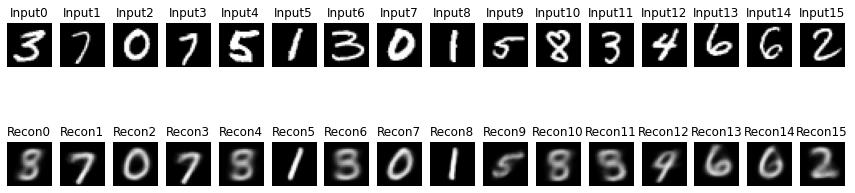

In [ ]:
test_x = next(iter(test_loader))[0]
test_x = test_x.to(device)
model.eval()
_, _, reconstruction_x = model(test_x)

test_x = test_x.detach().cpu().numpy()
reconstruction_x = reconstruction_x.detach().cpu().numpy()

n = 16
plt.figure(figsize=(15, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_x[i].reshape(28, 28), vmin=0, vmax=1, cmap='gray')
    plt.title('Input' + str(i))
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction_x[i].reshape(28, 28), vmin=0, vmax=1, cmap='gray')
    plt.title('Recon' + str(i))
    plt.axis('off')
plt.show()